# Slump Detection Notebook

Leverages slump-detection-11.1 environment. Feel free to clone the environment from my end.

## Generate the dataset

In here we generate the dataset for training.

In [1]:
CONFIG = 'config/slump_mask_rcnn_R_50_FPN_3x.yaml'
PREPROCESS = True
VIS = True
TRAIN = True
PREDICT = True

In [2]:
import os
import glob
import time
import torch
import numpy as np

In [3]:
import cv2
import xarray as xr
import rioxarray as rxr
from skimage.util import img_as_ubyte
from skimage import exposure
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from core.utils import arg_parser, get_bands, gen_data_png, gen_coco_dataset
from core.utils import predict_batch, arr_to_tif

In [5]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(22)

## Read configuration file

In [6]:
cfg = get_cfg()  # get default configurations in place
cfg.set_new_allowed(True)  # allow for new configuration objects
cfg.INPUT.MIN_SIZE_TRAIN = 256  # small hack to allow merging new fields
cfg.merge_from_file(CONFIG)  # merge from file

## Preprocessing

Extract dataset tiles from label and imagery rasters.

In [7]:
if PREPROCESS:
    # Process each image individually
    for image, label in zip(cfg.DATASETS.IMAGES, cfg.DATASETS.LABELS):

        # read input data
        image_data = rxr.open_rasterio(image).transpose("y", "x", "band")
        label_data = rxr.open_rasterio(label).squeeze().values.astype(np.uint8)
        print("Image and label shapes: ", image_data.shape, label_data.shape)

        # drop bands we are not interested in given the ones we actually want
        image_data = get_bands(
            image_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS
        ).values.astype(np.int16)
        print("Image after get_bands: ", image_data.shape, label_data.shape)

        # EVHR outputs values outside of allowed range [0,10000]
        image_data = np.clip(image_data, 0, 10000)

        # lower resolution here
        image_data = exposure.rescale_intensity(img_as_ubyte(image_data))

        # transforming 1 to 255 for now to visualize locally
        label_data[label_data == 1] = 255

        # extract tiles from the imagery and generate masks
        for set in ['TRAIN', 'TEST', 'VAL']:
            gen_data_png(image, image_data, label_data, cfg, set=set)
            gen_coco_dataset(
                cfg, set=set, img_reg='*_img_*.png', label_reg='*_lbl_*.png'
            )

Image and label shapes:  (1103, 951, 8) (1103, 951)
Image after get_bands:  (1103, 951, 3) (1103, 951)
Saving file under: /att/gpfsfs/briskfs01/ppl/jacaraba/slump-detection-data/TRAIN


  0%|          | 0/300 [00:00<?, ?it/s]

Number of train and mask images: 300 149 without annotations.
Saving file under: /att/gpfsfs/briskfs01/ppl/jacaraba/slump-detection-data/TEST


  0%|          | 0/25 [00:00<?, ?it/s]

Number of train and mask images: 60 17 without annotations.
Saving file under: /att/gpfsfs/briskfs01/ppl/jacaraba/slump-detection-data/VAL


  0%|          | 0/25 [00:00<?, ?it/s]

Number of train and mask images: 60 11 without annotations.


## Visualize some training tiles

Lets visualize some training tiles.

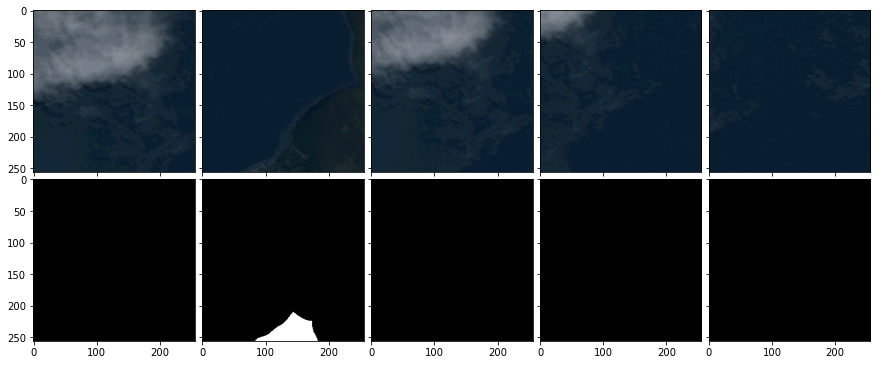

In [8]:
if VIS:

    vis_dir = os.path.join(cfg.DATASETS.OUTPUT_DIRECTORY, 'TRAIN')
    images = sorted(glob.glob(os.path.join(vis_dir, '*_img_*.png')))[:5]
    labels = sorted(glob.glob(os.path.join(vis_dir, '*_lbl_*.png')))[:5]

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im_id in zip(grid, images + labels):
        #print(ax, im_id)
        # Iterating over the grid returns the Axes.
        ax.imshow(cv2.imread(im_id))

    plt.show()

## Train

Train model using detectron2 framework.

In [9]:
if TRAIN:
    # Path and directory configurations
    input_dir = cfg.DATASETS.OUTPUT_DIRECTORY
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    dataset_name = cfg.DATASETS.COCO_METADATA.DESCRIPTION

    # Registor COCO datasets for train, val, and test
    for curType in ['TRAIN', 'VAL', 'TEST']:
        curJson = os.path.join(
            input_dir, dataset_name + '_' + curType + '.json'
        )
        curDir = os.path.join(input_dir, curType)
        register_coco_instances(
            f'{dataset_name}_{curType}', {}, curJson, curDir
        )

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    finalModelPath = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)

    if os.path.isfile(finalModelPath) and cfg.MODEL.DELETE_MODEL:
        os.remove(finalModelPath)
        print("WARNING: deleted existing model, re-training")

    if not os.path.isfile(finalModelPath):  # no re-run training unless cleared
        trainer = DefaultTrainer(cfg)
        trainer.resume_or_load(resume=False)
        trainer.train()

[08/03 12:55:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[08/03 12:55:58 d2.engine.train_loop]: Starting training from iteration 0
[08/03 12:56:46 d2.utils.events]:  eta: 0:01:26  iter: 19  total_loss: 1.813  loss_cls: 0.2181  loss_box_reg: 0.1845  loss_mask: 0.6932  loss_rpn_cls: 0.6851  loss_rpn_loc: 0.004527  time: 0.3017  data_time: 0.0841  lr: 0.00016068  max_mem: 2096M
[08/03 12:56:52 d2.utils.events]:  eta: 0:01:14  iter: 39  total_loss: 1.492  loss_cls: 0.1337  loss_box_reg: 0.1827  loss_mask: 0.6915  loss_rpn_cls: 0.4662  loss_rpn_loc: 0.00672  time: 0.2926  data_time: 0.0448  lr: 0.00032718  max_mem: 2096M
[08/03 12:56:57 d2.utils.events]:  eta: 0:01:08  iter: 59  total_loss: 1.151  loss_cls: 0.09875  loss_box_reg: 0.1796  loss_mask: 0.6867  loss_rpn_cls: 0.1655  loss_rpn_loc: 0.005833  time: 0.2892  data_time: 0.0424  lr: 0.00049367  max_mem: 2096M
[08/03 12:57:03 d2.utils.events]:  eta: 0:01:02  iter: 79  total_loss: 1.024  loss_cls: 0.0806  loss_box_reg: 0.1719  loss_mask: 0.6781  loss_rpn_cls: 0.05594  loss_rpn_loc: 0.006103  t

In [10]:
if PREDICT:
    # Path and directory configurations
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    # setting up model information
    model_weights = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)
    cfg.MODEL.WEIGHTS = model_weights

    # build model and model metadata
    model = build_model(cfg)  # build architecture and maps
    model_dict = torch.load(model_weights, map_location=torch.device('cpu'))
    model.load_state_dict(model_dict['model'])  # load metadata

    # TODO: In a later version, parellize the model over several GPUs.
    # import torch.nn as nn
    # model = nn.DataParallel(model)
    model.train(False)  # we are predicting, weights are already updated

    # Get list of files to predict
    if isinstance(cfg.PREDICTOR.PRED_FILENAMES, str):
        cfg.PREDICTOR.PRED_FILENAMES = glob.glob(cfg.PREDICTOR.PRED_FILENAMES)
    print(f'Number of files to predict: {len(cfg.PREDICTOR.PRED_FILENAMES)}')

    # Tterate over files and predict them
    cfg.PREDICTOR.PRED_FILENAMES = ['/att/nobackup/ewebb5/5-toas/WV02_20160709_M1BS_10300100591D6600-toa_pansharpen.tif']
    for fname in cfg.PREDICTOR.PRED_FILENAMES:

        # measure execution time
        start_time = time.perf_counter()

        # path + name to store prediction into
        save_image = \
            cfg.OUTPUT_DIR + '/' + fname[:-4].split('/')[-1] + '_pred.tif'

        # --------------------------------------------------------------------------------
        # if prediction is not on directory, start predicting
        # (allows for restarting script if it was interrupted at some point)
        # --------------------------------------------------------------------------------
        # if not os.path.isfile(save_image):

        print(f'Starting to predict {fname}')
        # --------------------------------------------------------------------------------
        # Extracting and resizing test and validation data
        # --------------------------------------------------------------------------------
        x_data = xr.open_rasterio(
            fname, chunks=dict(cfg.DATALOADER.DASK_SIZE)
        )
        x_data = get_bands(
            x_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS
        )

        # --------------------------------------------------------------------------------
        # Calculate missing indices
        # --------------------------------------------------------------------------------

        # --------------------------------------------------------------------------------
        # Getting predicted labels
        # --------------------------------------------------------------------------------
        prediction = predict_batch(x_data=x_data, model=model, config=cfg)
        prediction[prediction > 1] = 1
        prediction = prediction.astype(np.int8)  # type to int8

        # --------------------------------------------------------------------------------
        # Generating visualization from prediction
        # --------------------------------------------------------------------------------
        arr_to_tif(raster_f=fname, segments=prediction, out_tif=save_image)
        print(f'Saved image {save_image}.')
        del prediction

        # This is the case where the prediction was already saved
        # else:
        #    print(f'{save_image} already predicted.')

        print(f'Time: {(time.perf_counter() - start_time)}')

Number of files to predict: 1
Starting to predict /att/nobackup/ewebb5/5-toas/WV02_20160709_M1BS_10300100591D6600-toa_pansharpen.tif
wsize: 3200x3200. Prediction shape: (17944, 19854)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved image /att/gpfsfs/briskfs01/ppl/jacaraba/slump-detection-data/WV02_20160709_M1BS_10300100591D6600-toa_pansharpen_pred.tif.
Time: 1115.3789801718667


In [11]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
#predictor = DefaultPredictor(cfg)

In [12]:
#from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
#for d in random.sample(dataset_dicts, 3):    
#    im = cv2.imread(d["file_name"])
#    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#    v = Visualizer(im[:, :, ::-1],
#                   metadata=balloon_metadata, 
#                   scale=0.5, 
#                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
#    )
#    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#    cv2_imshow(out.get_image()[:, :, ::-1])